# Prédiction à l'aide de forêts aléatoires

Les forêts aléatoires sont des modèles de bagging ne nécessitant pas beaucoup de *fine tuning* pour obtenir des performances correctes. De plus, ces méthodes sont plus résitances au surapprentissage par rapport à d'autres méthodes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dossier_donnees = "/content/drive/My Drive/projet_info_Ensae"

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import numpy as np
from matplotlib import pyplot as plt


## Lecture des données de train et validation

In [4]:
donnees = pd.read_csv(dossier_donnees + "/donnees_model/donnees_train.csv", index_col = 1)

In [5]:
donnees_validation =  pd.read_csv(dossier_donnees + "/donnees_model/donnees_validation.csv", index_col = 1)

In [6]:
donnees.drop(columns= "Unnamed: 0", inplace = True)

In [7]:
donnees_validation.drop(columns= "Unnamed: 0", inplace = True)

On va faire quelques petites modifications sur les donnees : 
- Les variables `arrondissement`, `pp`, `mois` vont être considérées comme variable catégorielle
- Les variables `datemut` vont être supprimées
- La variable `sbati_squa` est retirée en suivant les recommandations de Maître Wenceslas Sanchez.

In [8]:
donnees["arrondissement"] = donnees["arrondissement"].astype("object")

donnees["pp"] = donnees["pp"].astype("object")

donnees["mois"] = donnees["datemut"].str[5:7].astype("object")

donnees_train = donnees.drop(columns = ["nblot", "nbpar", "nblocmut", "nblocdep","datemut","sbati_squa"])


In [9]:
donnees_validation["arrondissement"] = donnees_validation["arrondissement"].astype("object")

donnees_validation["pp"] = donnees_validation["pp"].astype("object")

donnees_validation["mois"] = donnees_validation["datemut"].str[5:7].astype("object")

donnees_validation.drop(columns = ["nblot", "nbpar", "nblocmut", "nblocdep","datemut","sbati_squa"], inplace = True)

In [10]:
donnees_train.rename(columns = {"valfoncact2" : "valfoncact"}, inplace = True)
donnees_validation.rename(columns = {"valfoncact2" : "valfoncact"}, inplace = True)

In [11]:
def preparation(table):
  #Restriction à certains biens
  table = table[(table["valfoncact"] > 1e5) & (table["valfoncact"] < 3*(1e6))]
  #Ajout données brut
  men_brut = table.loc[:, "Men":"Men_mais"].apply(lambda x : x*table["Men"], axis = 0).add_suffix("_brut")
  ind_brut = table.loc[:, "Ind_0_3":"Ind_80p"].apply(lambda x : x*table["Ind"], axis = 0).add_suffix("_brut")
  table = pd.concat([table, men_brut, ind_brut],axis = 1)
  table_X = table.drop(columns = ["valfoncact"]).to_numpy()
  table_Y = table["valfoncact"].to_numpy()
  nom = table.drop(columns = ["valfoncact"]).columns
  return(table_X,table_Y,nom)

In [12]:
donnees_validation_prep_X,donnees_validation_prep_Y,nom = preparation(donnees_validation)
donnees_train_prep_X,donnees_train_prep_Y,nom = preparation(donnees_train)

## Modélisation


In [ ]:
rf = RandomForestRegressor(random_state=42,n_jobs = -1)

Pour le choix du nombre de variables testés à chaque split, Breiman [2000] recommande qu'utiliser dans les problèmes de régression $\sqrt{p}$ comme valeur où p désigne le nombre de covariables. Ici $p$ vaut 67. On prendra donc $p = 8$ ainsi que $6$ et $16$.

Le nombre d'arbres (`n_estimators`) n'est *a priori* pas le critère le plus déterminant dans la performance des forêts aléatoires au delà d'un certain seuil. Nous essayons ici des valeurs *conventionnelles*.

Pour contrôler la profondeur des feuilles de chaque arbre CART, nous utilisons le nombre d'individus minimums dans chaque feuille de l'arbre. Plus il est grand, plus l'arbre sera petit. Notons que les arbres ne sont pas élagués ici.

In [ ]:
param_grid = { 
    'n_estimators': [100,200,500,1000],
    'max_features': [6,8,16],
    'min_samples_leaf' : [1,2,5,10]
}

In [ ]:
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, verbose=2, n_jobs = -1)

In [ ]:
rf_grid_search.fit(donnees_train_prep_X, donnees_train_prep_Y)
print(rf_grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 62.9min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 396.5min finished


{'max_features': 16, 'min_samples_leaf': 2, 'n_estimators': 1000}


In [13]:
rf2 = RandomForestRegressor(random_state=42,n_jobs = -1, max_features = 16, min_samples_leaf= 2, n_estimators= 1000)

In [14]:
rf2.fit(donnees_train_prep_X,donnees_train_prep_Y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=16, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [15]:
pred = rf2.predict(donnees_validation_prep_X)

In [16]:
np.sqrt(metrics.mean_squared_error(donnees_validation_prep_Y,pred))

143325.41074173173

## Visualisation de l'importance des variables

Afin de savoir quelles sont les variables les plus importantes dans la prédiction, nous allons utiliser l'importance des variables. Il s'agit ici d'une importance basée sur la diminution de l'indice de Gini.

Text(0.5, 0, 'Random Forest Feature Importance')

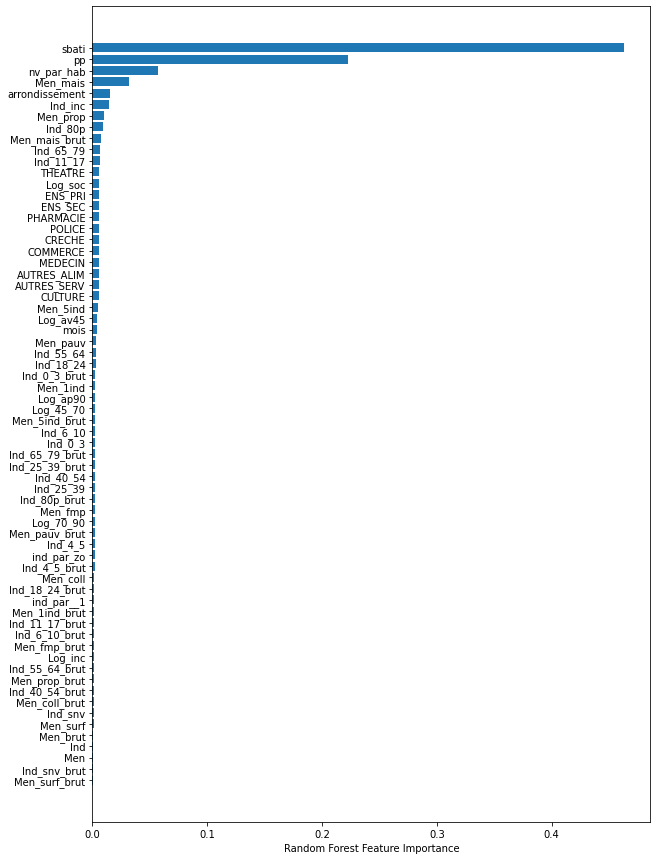

In [17]:
sorted_idx = rf2.feature_importances_.argsort()
plt.figure(figsize=(10,15))
plt.barh(nom[sorted_idx], rf2.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

On note que les variables les plus importantes pour la prédiction sont : 
- sbati : la surface du bien
- pp : le nombre de pièces
- nv_par_hab : le niveau de vie par habitant du carreaux de 200 mètres dans lequel le bien se situe
- Men_mai : Part de ménages en maison
- arrondissement : Arrondissement dans lequel se situe le bien
- Men_prop : Part de ménages propriétaires
- Ind_80p : Part de plus de 80 ans
- Ind_65_79 : Part d'individus âgés entre 65 et 79 ans
- Men_mai_brut : Nombre bruts de ménages en maison